<a href="https://colab.research.google.com/github/bharaniakella/Akellian_DL/blob/main/Ann_depth_vs_breadth_with_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [53]:
# import dataset
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

In [54]:
class AnnDepthVsBreadth(nn.Module):
  def __init__(self,nUnits,nLayers):
    super().__init__()
    self.nUnits=nUnits
    self.nLayers=nLayers

    self.layers=nn.ModuleDict()

    self.layers['input']=nn.Linear(4,self.nUnits)

    for i in range(self.nLayers):
      self.layers[f'hidden{i}']=nn.Linear(self.nUnits,self.nUnits)

    self.layers['output']=nn.Linear(self.nUnits,3)

  def forward(self,x):
    x=self.layers['input'](x)
    x=F.relu(x)

    for i in range(self.nLayers):
      x=self.layers[f'hidden{i}'](x)
      x=F.relu(x)

    x=self.layers['output'](x)

    return x


In [55]:
# a function to train the model

def trainTheModel(theModel):

  # define the loss function and optimizer
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(theModel.parameters(),lr=.01)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = theModel(data)

    # compute loss
    loss = lossfun(yHat,labels)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



  # final forward pass to get accuracy
  predictions = theModel(data)
  predlabels = torch.argmax(predictions,axis=1)
  acc = 100*torch.mean((predlabels == labels).float())

  # total number of trainable parameters in the model
  nParams = sum(p.numel() for p in theModel.parameters() if p.requires_grad)

  # function outputs
  return acc,nParams

In [56]:
# test the function once

numepochs = 500
net=AnnDepthVsBreadth(128,5)
acc = trainTheModel(net)

# check the outputs
acc # tuple containing (accuracy,nparams)

(tensor(66.6667), 83587)

In [57]:
numlayers = range(1,6)         # number of hidden layers
numunits  = np.arange(4,101,3) # units per hidden layer

# initialize output matrices
accuracies  = np.zeros((len(numunits),len(numlayers)))
totalparams = np.zeros((len(numunits),len(numlayers)))

# number of training epochs
numepochs = 500


# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create a fresh model instance
    net = AnnDepthVsBreadth(numunits[unitidx],numlayers[layeridx])

    # run the model and store the results
    acc,nParams = trainTheModel(net)
    accuracies[unitidx,layeridx] = acc

    # store the total number of parameters in the model
    totalparams[unitidx,layeridx] = nParams


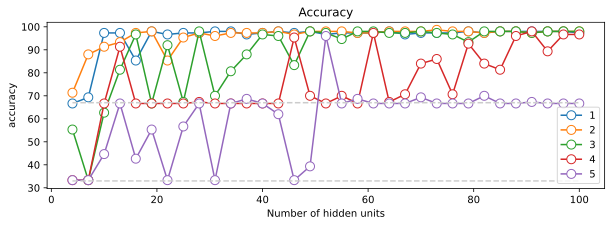

In [60]:
# show accuracy as a function of model depth
fig,ax = plt.subplots(1,figsize=(10,3))

ax.plot(numunits,accuracies,'o-',markerfacecolor='w',markersize=9)
ax.plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.legend(numlayers)
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()